In [1]:
from CryOption_OPT import optionModel,preInit

C:\Users\5565\AppData\Local\Programs\Python\Python310\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


# Collect Deribit option data

In [2]:
import requests
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from datetime import datetime
import random
import time
from tqdm.notebook import tqdm
#most of the code comes from this repo https://github.com/schepal/deribit_data_collector/blob/master/deribit_data.py

def request_get(url):
    while True:
        try:
            page = requests.get(url)
            return page.json()['result']
        except:time.sleep(random.randint(1,5))
        
def get_options_list():
    data = {'currency': currency, 'kind': 'option'}
    r = requests.get(url + 'get_instruments', data)
    df = pd.DataFrame(r.json()['result'])
    cols = ['expiration_timestamp', 'option_type', 'instrument_name', 'strike']
    return df[cols]
def get_option_urls():
    url_storage = []
    options_list = get_options_list()
    request_url = url + 'get_order_book?instrument_name='
    for option in range(len(options_list)):
        data = request_url + options_list.instrument_name.values[option]
        url_storage.append(data)
    return url_storage
def collect_clean_data():

    raw_data = []
    pool = ThreadPoolExecutor(max_workers=10)
    print("Collecting data...")
    urls = get_option_urls()
    for asset in tqdm(pool.map(request_get,urls ),total=len(urls)):
        raw_data.append(asset)
    data = pd.DataFrame(raw_data)

    option_data = data
    option_data['infos'] = option_data['instrument_name'].apply(lambda x: x.split('-'))
    option_data['expiration'] = option_data['infos'].apply(
        lambda x: pd.to_datetime(x[1]))  # pd.to_datetime(option_data['expiration'])#
    option_data['is_call'] = option_data['infos'].apply(lambda x: x[-1])
    option_data['K'] = option_data['infos'].apply(lambda x: x[-2])
    option_data['ticker'] = option_data['infos'].apply(lambda x: x[0])
    option_data['askIv'] = option_data['ask_iv'] / 100  # option_data['askIV']#
    option_data['bidIv'] = option_data['bid_iv'] / 100  # option_data['bidIV']#
    option_data[['K', 'bidIV', 'askIV']] = option_data[['K', 'bidIv', 'askIv']].astype('float')

    option_data['expiry'] = option_data['expiration'].apply(lambda x: (pd.to_datetime(x) - datetime.now()) / (pd.to_timedelta('365d')))

    option_data = option_data[['is_call','K','askIV','bidIV','expiry','expiration']]
    expirList = option_data.sort_values(by=['expiration'])['expiration'].unique()


    return option_data,expirList

In [3]:
global currency
global url
currency = 'ETH'
url = 'https://www.deribit.com/api/v2/public/'
option_data,expirList = collect_clean_data()

  0%|          | 0/588 [00:00<?, ?it/s]

In [4]:
expirList

array(['2023-06-18T00:00:00.000000000', '2023-06-19T00:00:00.000000000',
       '2023-06-20T00:00:00.000000000', '2023-06-23T00:00:00.000000000',
       '2023-06-30T00:00:00.000000000', '2023-07-07T00:00:00.000000000',
       '2023-07-28T00:00:00.000000000', '2023-08-25T00:00:00.000000000',
       '2023-09-29T00:00:00.000000000', '2023-12-29T00:00:00.000000000',
       '2024-03-29T00:00:00.000000000'], dtype='datetime64[ns]')

In [5]:
# choose a expiry date, doesn't support mutiple expiry dates at the moment
expirDate = '2023-06-30T00:00:00.000000000'

In [6]:
# this is what the option Dataframe should look like 
option_data

,is_call,K,askIV,bidIV,expiry,expiration
0,C,1400.0,8.9069,0.0000,-0.000016,2023-06-18
1,P,1400.0,2.5401,0.0000,-0.000016,2023-06-18
2,C,1450.0,0.0000,0.0000,-0.000016,2023-06-18
3,P,1450.0,1.9455,0.0000,-0.000016,2023-06-18
4,C,1500.0,7.8761,0.0000,-0.000016,2023-06-18
...,...,...,...,...,...,...
583,P,6500.0,0.0000,0.0000,0.780806,2024-03-29
584,C,7000.0,0.7838,0.7268,0.780806,2024-03-29
585,P,7000.0,0.0000,0.0000,0.780806,2024-03-29
586,C,7500.0,0.8013,0.7546,0.780806,2024-03-29


# Collect price data, this is used for determine asset price range

In [7]:
import ccxt
def fetchprice(symbol,exchange = 'binance'):
    res = {}
    exchange = getattr(ccxt, exchange)()


    while True:
        try:
            data = exchange.fetch_ohlcv(symbol, '15m', None, 1000)
            header = ["Timestamp", "open", "high", "low", "close", "volume"]
            df = pd.DataFrame(data, columns=header)
            df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
            break
        except Exception as e:
            print(e)
            time.sleep(1)
    for i in range(20):
        while True:
            try:
                since = df.Timestamp.values[0] - 1000*15*60*1000
                data = exchange.fetch_ohlcv(symbol, '15m', since, 1000)
                header = ["Timestamp", "open", "high", "low", "close", "volume"]
                df1 = pd.DataFrame(data, columns=header)
                df1 = df1[["Timestamp", "open", "high", "low", "close", "volume"]]
                df = pd.concat([df1,df]).reset_index(drop=True)
                break
            except Exception as e:
                print(e)
                time.sleep(1)
    df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'] / 1000, unit="s")
    df["open"] = pd.to_numeric(df["open"])
    df["high"] = pd.to_numeric(df["high"])
    df["low"] = pd.to_numeric(df["low"])
    df["close"] = pd.to_numeric(df["close"])
    df["volume"] = pd.to_numeric(df["volume"])
    return df

In [8]:
pricedata = fetchprice('ETHUSDT')

In [9]:
# this is what the price Dataframe should look like 
pricedata

,Timestamp,open,high,low,close,volume
0,2022-11-10 22:15:00,1310.47,1319.14,1310.17,1314.94,4734.1857
1,2022-11-10 22:30:00,1314.94,1327.64,1314.31,1322.43,7544.0110
2,2022-11-10 22:45:00,1322.43,1329.87,1322.17,1324.14,4088.5653
3,2022-11-10 23:00:00,1324.14,1327.83,1316.66,1316.67,5554.5665
4,2022-11-10 23:15:00,1316.68,1318.28,1286.59,1296.99,20954.9330
...,...,...,...,...,...,...
20995,2023-06-17 15:00:00,1734.99,1736.30,1732.91,1733.61,1099.8239
20996,2023-06-17 15:15:00,1733.61,1735.75,1717.92,1732.97,11064.5923
20997,2023-06-17 15:30:00,1732.98,1734.92,1725.37,1728.27,3556.0535
20998,2023-06-17 15:45:00,1728.28,1730.76,1727.64,1727.88,2455.6887


In [10]:
# this part of the code is for pre-compute

preOption,joined1,price = preInit.Prep( expirDate, optionDf = option_data, priceDf = pricedata, interval=3, strikePriceRange=0.2)

C:\Users\5565\AppData\Local\Programs\Python\Python310\Scripts\script\CryOption_OPT\preInit.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_data['per_ivs'] = option_data['bidIV'].apply(lambda x: list(np.linspace(1 * lowerIV, 1 * upperIV, 89)), 0)


In [11]:
# this part of the code is for loop through all the possible option combination of 4 call options, 1 stands for call option
# -1 stands for put options, possible input for "optionstypes" should be a two dimension list, eg. [[1,1,1],[-1,-1,1,1]]
# maxquantity is the input for maxmium possible quantity for a single option trade amount 

model = optionModel.option_model(price, joined1,preOption,optionstypes = [[1,1,1,1],[1,1]], maxquantity=3)  # Init

df = model.options_model_finder()                                                                           # start looping

C:\Users\5565\AppData\Local\Programs\Python\Python310\Scripts\script\CryOption_OPT\optionModel.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(optionstypes)
100%|█████████████████████████████████████████████████████████████████████████████| 2451/2451 [00:19<00:00, 124.90it/s]


In [12]:
# output contains all the possible combinations given the parameters, you can filter out the result as you want
df

,para,stra,loss,probal,RR,wv,wp,bv,bp,delta_starting,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium
0,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_1__C_1700_1__C_1750_1__C_1850_1,1.000000,0.561798,7.449857,0.85,1351.047155,0.85,2318.214272,1.944630,2.441927,1.490606,1.838782,-4.209692,2.818043,280.816235
1,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_1__C_1700_1__C_1750_1__C_1850_2,1.000000,0.550562,8.726399,0.85,1351.047155,0.85,2318.214272,2.120732,2.927484,1.897431,2.290981,-4.997317,3.363380,292.098980
2,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_1__C_1700_1__C_1750_1__C_1850_3,1.000000,0.550562,9.907993,0.85,1351.047155,0.85,2318.214272,2.296833,3.413040,2.307954,2.743181,-5.784941,3.992559,303.381725
3,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_1__C_1700_1__C_1750_1__C_1850_4,1.000000,0.550562,11.004850,0.85,1351.047155,0.85,2318.214272,2.472935,3.898596,2.720502,3.195380,-6.572566,4.671828,314.664470
4,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_1__C_1700_1__C_1750_1__C_1850_-1,1.000000,0.561798,4.527023,0.85,1351.047155,0.85,2318.214272,1.606537,1.470829,0.711310,0.958395,-2.710784,2.238043,279.175065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,"[1726.09, [0.03286056547282471, 0.032860565441...",C_1750_-4__C_1800_-3,19.324091,0.460674,0.051749,0.85,2318.214272,0.85,1351.047155,2.539953,3.960625,2.960027,-2.613270,4.225678,4.559984,188.323298
2447,"[1726.09, [0.03286056547282471, 0.032860565441...",C_1750_-4__C_1850_-3,21.558570,0.460674,0.046385,0.85,2318.214272,0.85,1351.047155,2.208531,3.807410,2.927967,-2.728807,4.463454,4.461452,163.020078
2448,"[1726.09, [0.032860565441083206, 0.03286056544...",C_1800_-4__C_1800_-3,27.668664,0.483146,0.036142,0.85,2318.214272,0.85,1351.047155,1.907262,3.756299,2.982524,-2.727724,4.424175,4.821737,126.531877
2449,"[1726.09, [0.032860565441083206, 0.03286056544...",C_1800_-4__C_1850_-3,33.352920,0.494382,0.029982,0.85,2318.214272,0.85,1351.047155,1.575841,3.603084,2.963472,-2.843260,4.661951,4.900969,101.228656


In [13]:
temp = df.loc[  (df['probal']>0.5)&(df['mean_vega']>0)].sort_values(by=['mean_vega','probal'], ascending=[False,False])
temp

,para,stra,loss,probal,RR,wv,wp,bv,bp,delta_starting,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium
1603,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_4__C_1700_3__C_1750_4__C_1850_4,1.0,0.561798,7.367609,0.85,1351.047155,0.85,2318.214272,7.175508,9.128943,5.564271,6.977372,-16.169437,10.618631,1060.424136
1655,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_4__C_1700_4__C_1750_3__C_1850_4,1.0,0.561798,7.207383,0.85,1351.047155,0.85,2318.214272,7.342658,9.180014,5.545663,6.972744,-16.192675,10.629854,1087.218009
1661,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_4__C_1700_4__C_1750_4__C_1850_3,1.0,0.561798,7.114531,0.85,1351.047155,0.85,2318.214272,7.602419,9.282153,5.559436,6.902927,-16.051145,10.803755,1111.982194
1175,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_3__C_1700_4__C_1750_4__C_1850_4,1.0,0.561798,8.209571,0.85,1351.047155,0.85,2318.214272,7.048868,9.037800,5.691427,6.728681,-14.732128,10.269912,952.619182
1595,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_4__C_1700_3__C_1750_3__C_1850_4,1.0,0.561798,7.107365,0.85,1351.047155,0.85,2318.214272,6.739645,8.541248,5.147619,6.594989,-15.523343,9.978973,1024.377206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_1__C_1700_-1__C_1750_4__C_1850_-4,1.0,0.561798,1.297642,0.85,1351.047155,0.85,1856.611784,1.214768,0.500007,0.440309,0.099586,-1.281416,2.676816,412.052538
231,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_1__C_1700_4__C_1750_-1__C_1850_-4,1.0,0.584270,1.143354,0.85,1351.047155,0.85,1856.611784,2.063097,0.755355,0.723123,0.063654,-1.356436,3.849319,494.099108
15,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_1__C_1700_1__C_1750_2__C_1850_-4,1.0,0.573034,1.247072,0.85,1351.047155,0.85,1856.611784,1.556423,0.602150,0.553468,0.056217,-1.223027,3.103012,344.146721
71,"[1726.09, [0.03286056547282471, 0.032860565472...",C_1600_1__C_1700_2__C_1750_1__C_1850_-4,1.0,0.573034,1.212329,0.85,1351.047155,0.85,1856.611784,1.723573,0.653217,0.609230,0.051589,-1.246266,3.345129,370.940594


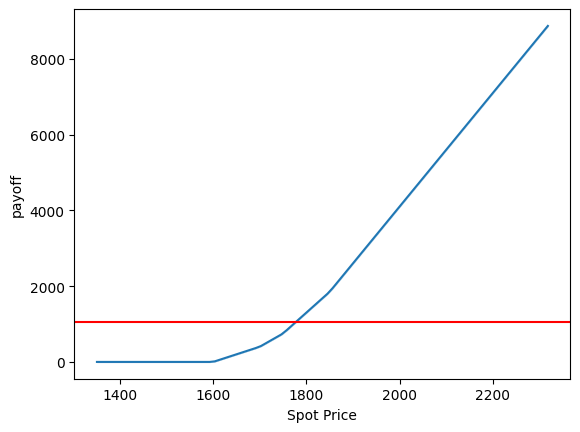

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1060.424135669389
premium 1060.424135669389
Risk Reward 7.367608561621285
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -33.642075742316536
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


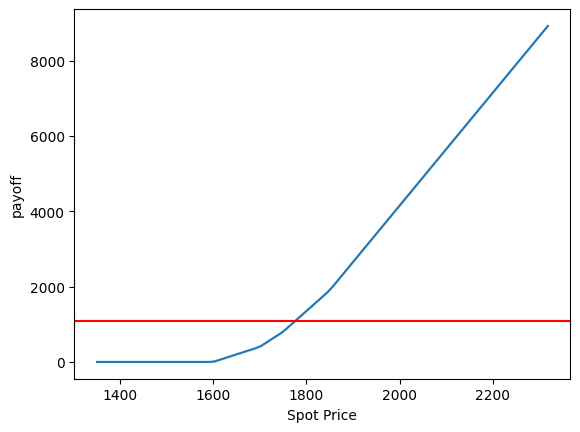

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1087.2180087567983
premium 1087.2180087567983
Risk Reward 7.207382516391963
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -33.558861025003104
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


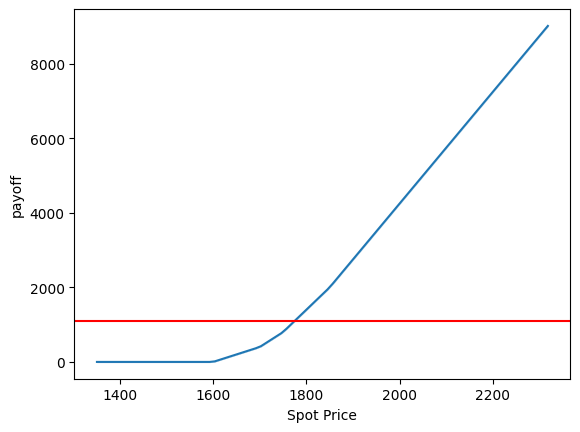

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1111.9821935489078
premium 1111.9821935489078
Risk Reward 7.114531085951392
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -34.10083442839291
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


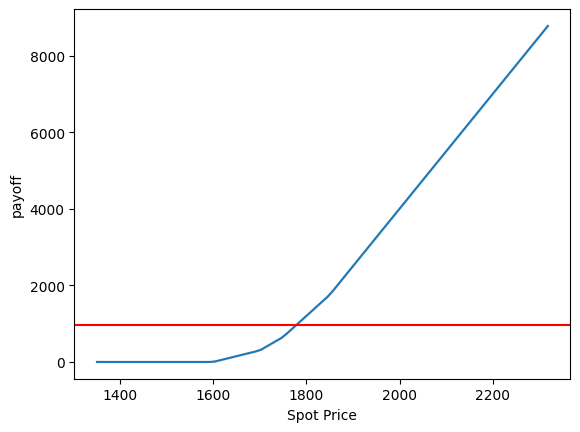

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 952.6191815880933
premium 952.6191815880933
Risk Reward 8.209571092145524
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -32.267985238446
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


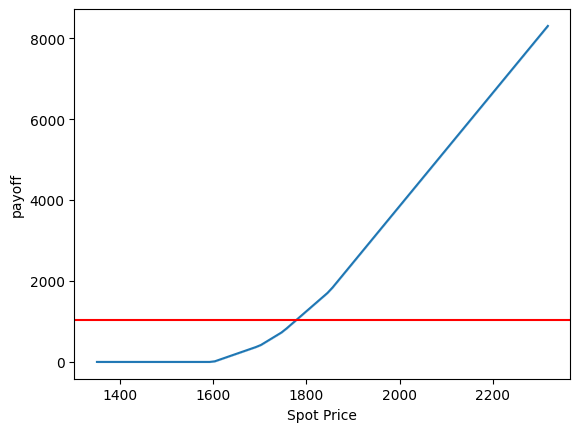

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1024.3772058760037
premium 1024.3772058760037
Risk Reward 7.107364901489728
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -31.602878600423644
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


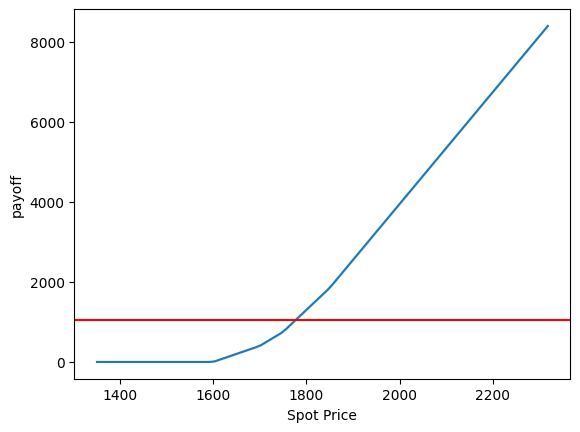

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1049.1413906681132
premium 1049.1413906681132
Risk Reward 7.011312754949802
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -32.09106386957759
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


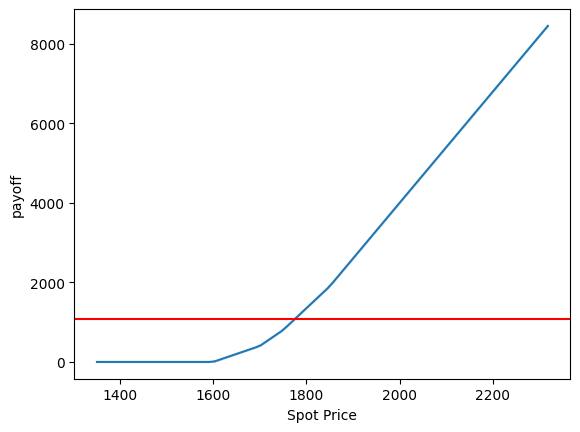

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1075.9352637555226
premium 1075.9352637555226
Risk Reward 6.8582792939542525
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -32.084337386605355
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


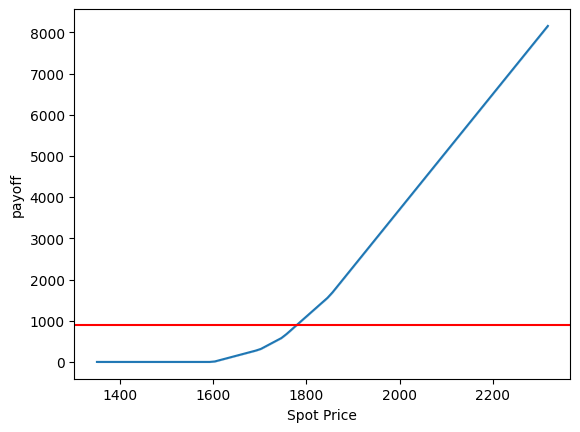

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 889.7783787072987
premium 889.7783787072987
Risk Reward 8.165203380928517
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -30.35206760337921
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


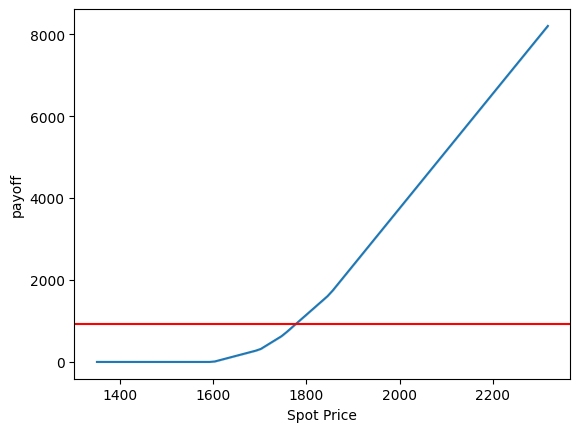

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 916.5722517947081
premium 916.5722517947081
Risk Reward 7.951830899025479
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -30.22878809655311
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


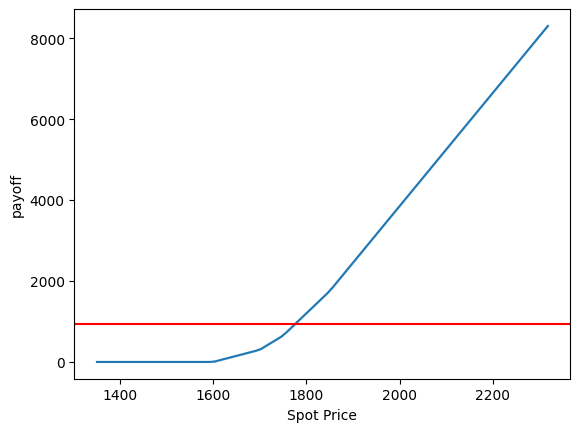

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 941.3364365868175
premium 941.3364365868175
Risk Reward 7.822562775662064
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -30.69372319164435
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


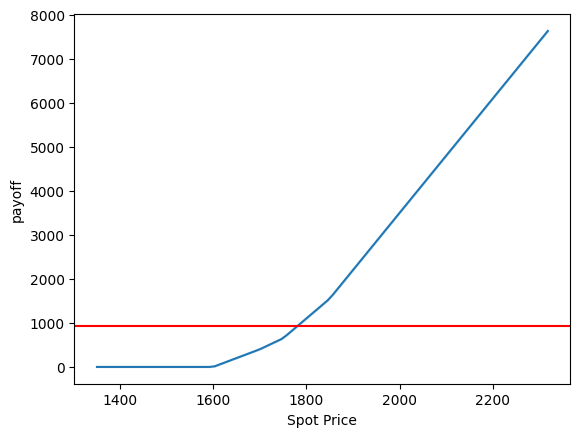

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 934.7425299077997
premium 934.7425299077997
Risk Reward 7.169934809520966
probal 0.550561797752809
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -29.819390297209523
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


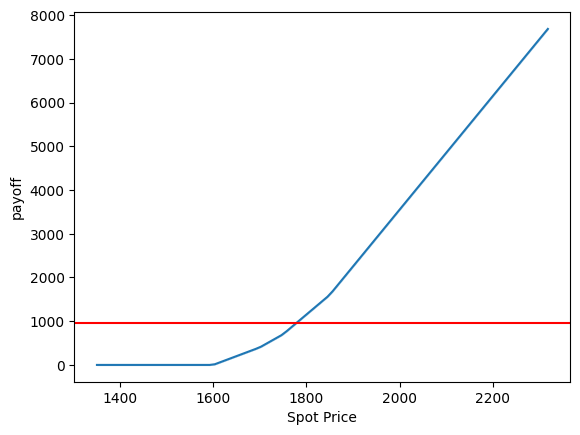

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 961.5364029952091
premium 961.5364029952091
Risk Reward 6.994274069176065
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -29.664525575594183
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


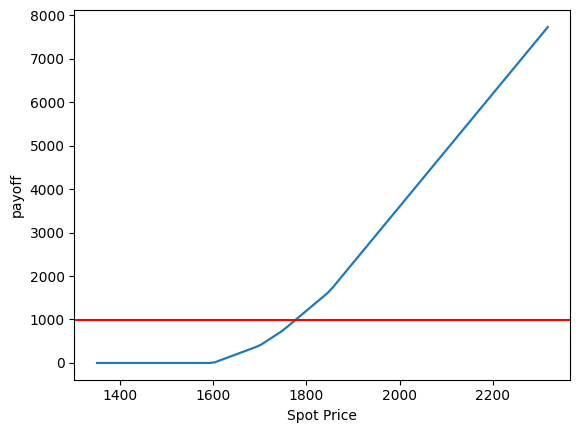

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 988.3302760826185
premium 988.3302760826185
Risk Reward 6.828137739237564
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -29.563681458530752
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


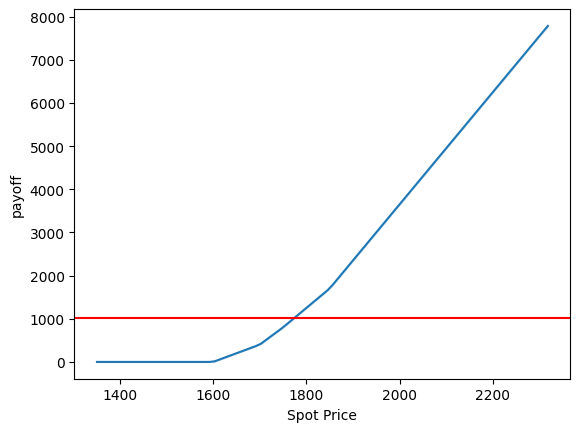

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1015.124149170028
premium 1015.124149170028
Risk Reward 6.670771638523182
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -29.50168999796621
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


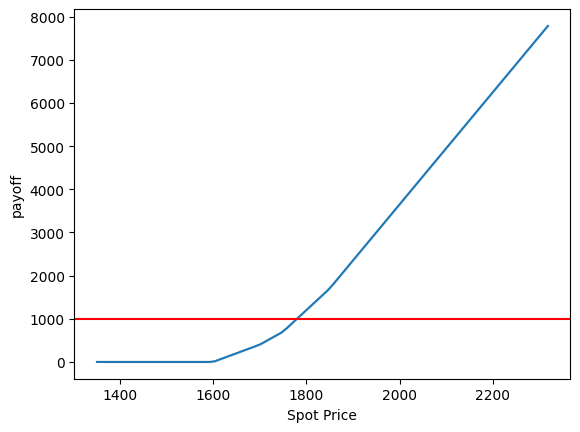

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 986.3005877873186
premium 986.3005877873186
Risk Reward 6.894941592301406
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -30.111831270935422
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


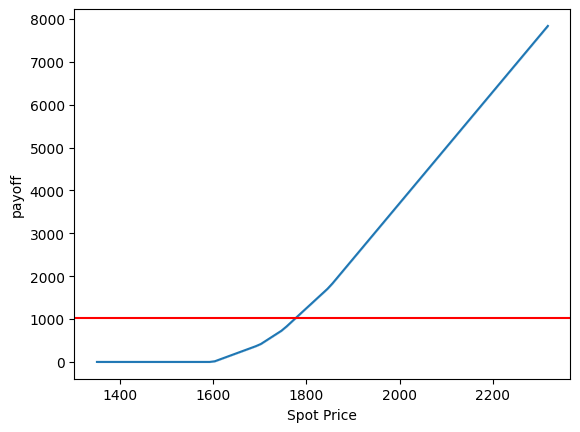

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1013.0944608747279
premium 1013.0944608747279
Risk Reward 6.735493417136025
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -30.074566827790036
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


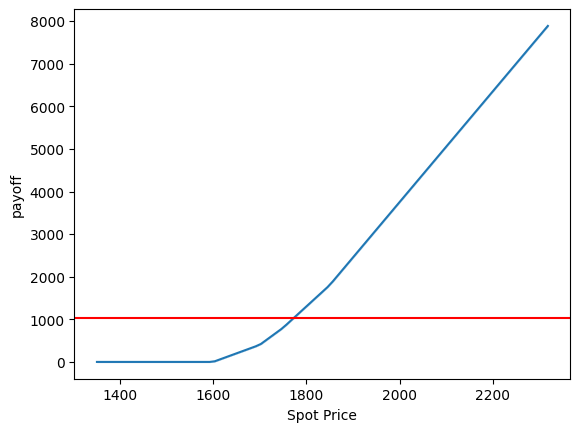

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1039.8883339621373
premium 1039.8883339621373
Risk Reward 6.584261959150497
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -30.06978451493427
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


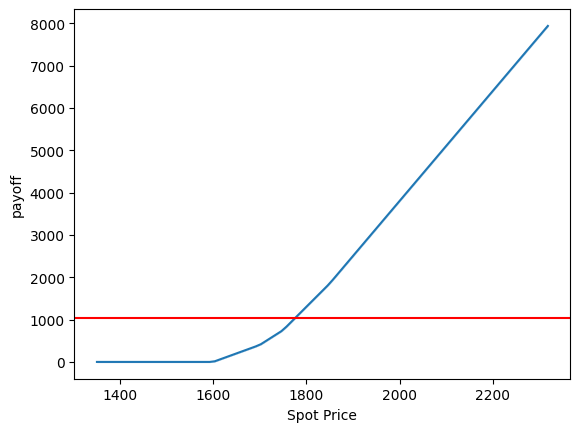

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1037.8586456668374
premium 1037.8586456668374
Risk Reward 6.6472702387461835
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -30.648285290680032
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 2, 'map': 1}]


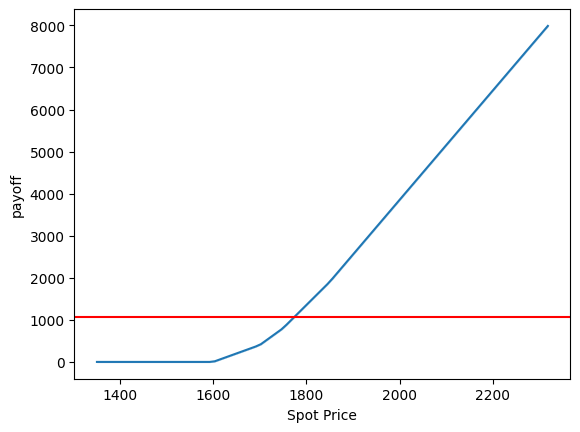

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1064.6525187542468
premium 1064.6525187542468
Risk Reward 6.501776769737782
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -30.721037988737283
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 2, 'map': 1}]


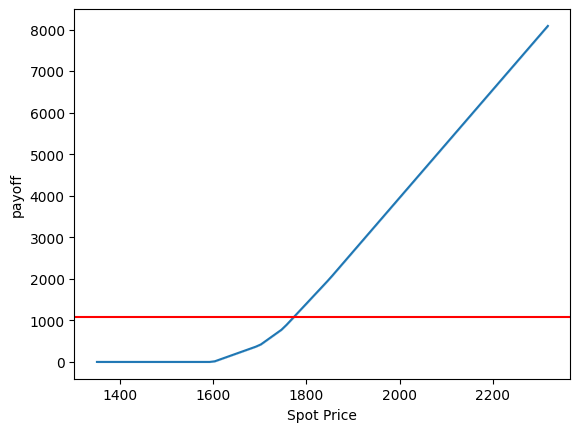

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1089.4167035463563
premium 1089.4167035463563
Risk Reward 6.423041620996517
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -31.38918994283617
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 1, 'map': 1}]


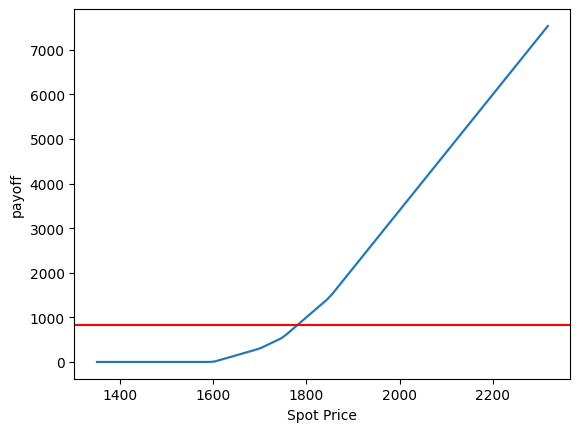

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 826.937575826504
premium 826.937575826504
Risk Reward 8.114092470039944
probal 0.550561797752809
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -28.463284345304942
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


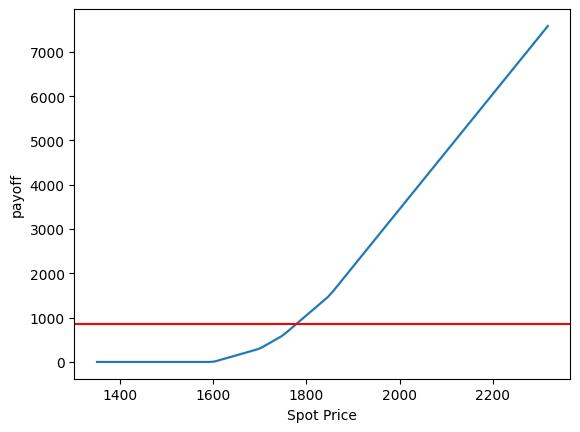

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 853.7314489139135
premium 853.7314489139135
Risk Reward 7.886618318541577
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -28.308419623689602
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


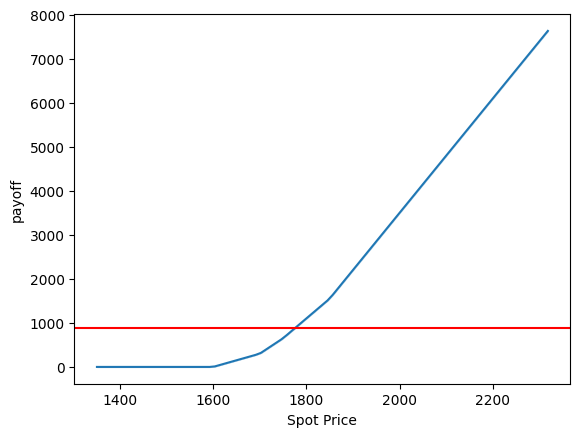

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 880.5253220013228
premium 880.5253220013228
Risk Reward 7.672987979125891
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -28.18959095466022
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


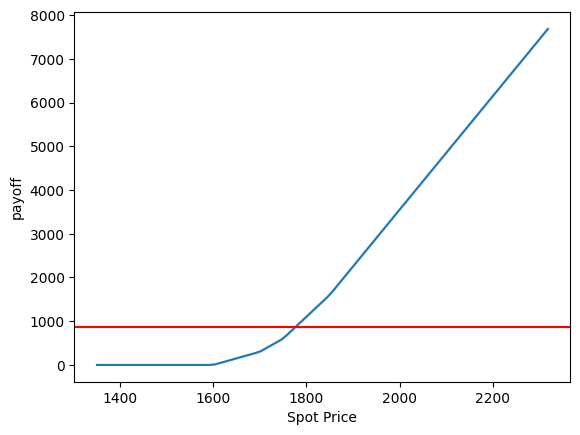

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 878.4956337060229
premium 878.4956337060229
Risk Reward 7.749941648094415
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -28.73774076706489
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


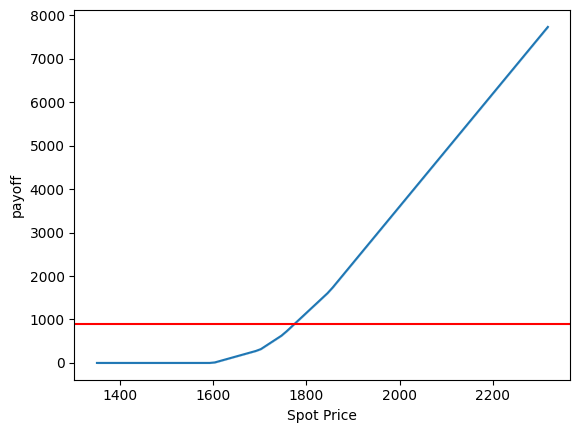

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 905.2895067934323
premium 905.2895067934323
Risk Reward 7.5462003866999385
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -28.67315640131197
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


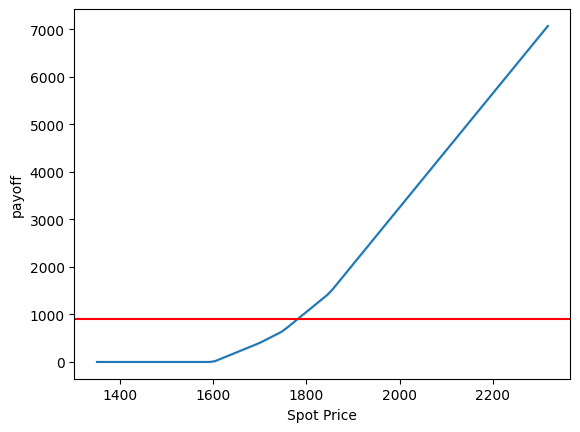

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 898.6956001144144
premium 898.6956001144144
Risk Reward 6.8653676065196185
probal 0.550561797752809
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -27.775742317519914
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


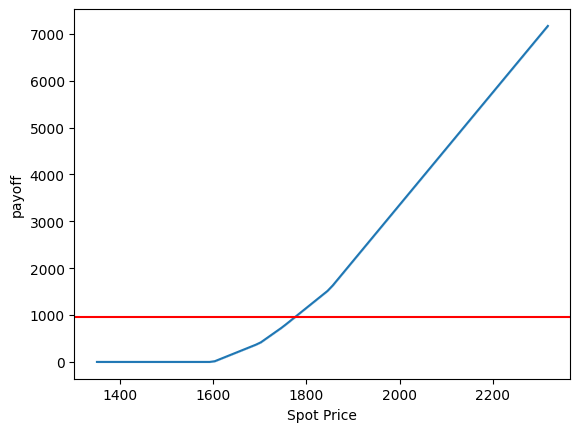

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 952.2833462892334
premium 952.2833462892334
Risk Reward 6.527771318479345
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -27.52448431663786
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


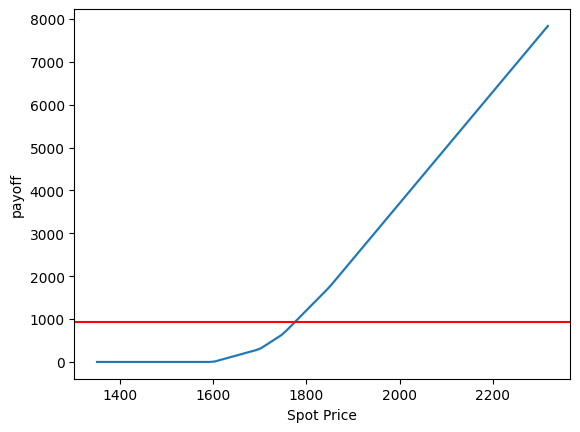

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 930.0536915855417
premium 930.0536915855417
Risk Reward 7.426164643971673
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -29.23930674816356
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 2, 'map': 1}]


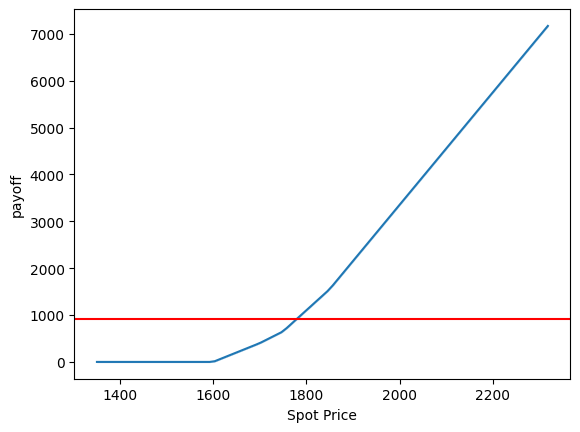

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 923.459784906524
premium 923.459784906524
Risk Reward 6.762732474579013
probal 0.550561797752809
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -28.155848846355962
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


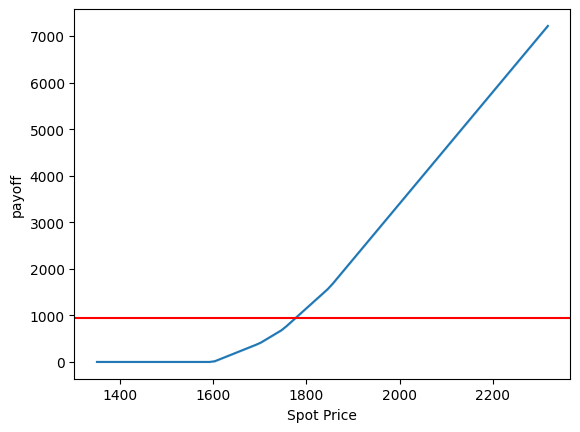

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 950.2536579939333
premium 950.2536579939333
Risk Reward 6.596467743676615
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -28.07263412904253
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


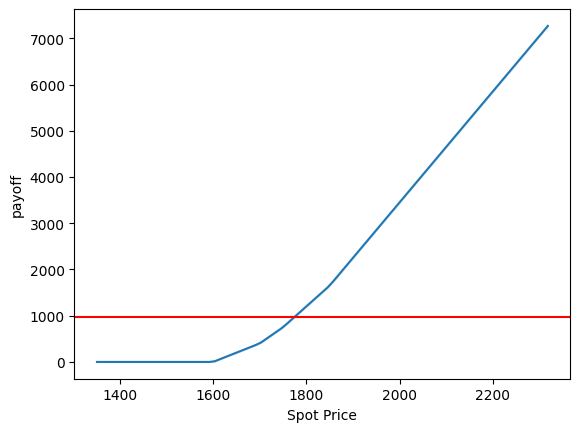

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 977.0475310813428
premium 977.0475310813428
Risk Reward 6.4393220698456375
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -28.058069786002484
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


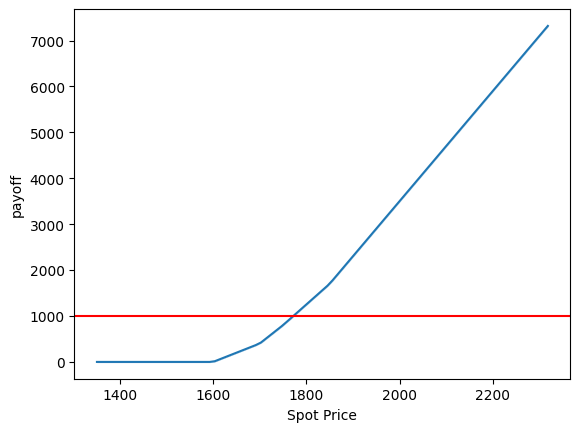

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1003.8414041687522
premium 1003.8414041687522
Risk Reward 6.290565253504253
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -28.094021360963495
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


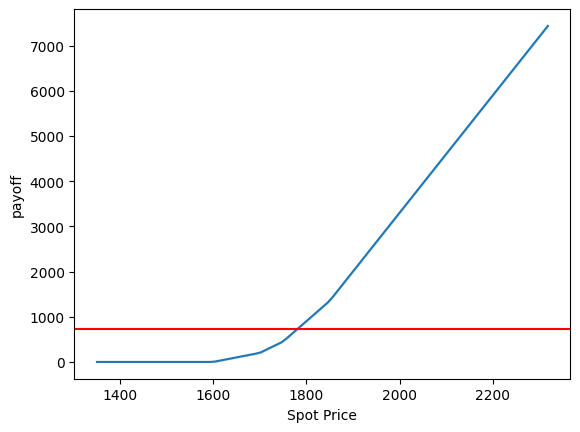

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 719.1326217452084
premium 719.1326217452084
Risk Reward 9.341326909889938
probal 0.550561797752809
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -27.10717839340036
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


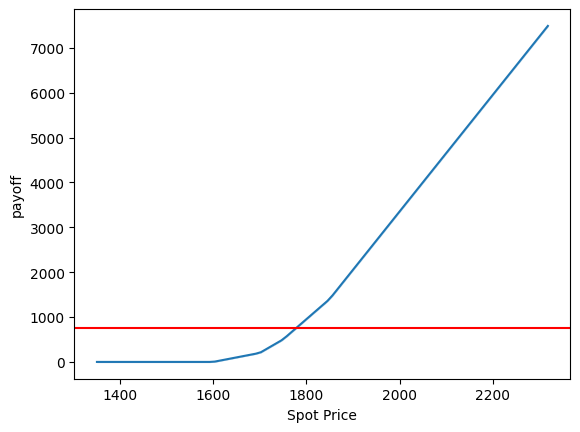

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 745.9264948326179
premium 745.9264948326179
Risk Reward 9.036894499522266
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -26.95231367178502
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


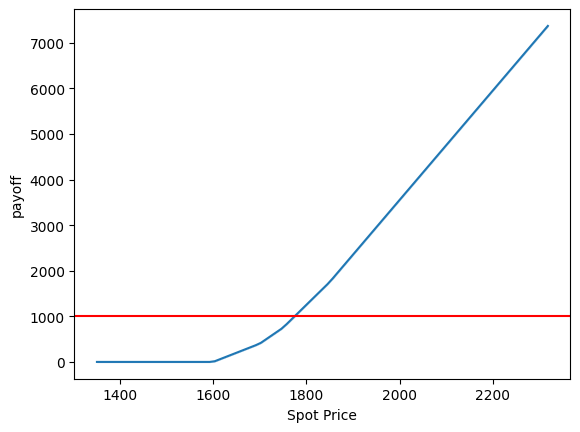

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1001.8117158734522
premium 1001.8117158734522
Risk Reward 6.355245645971679
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -28.672522136709258
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 2, 'map': 1}]


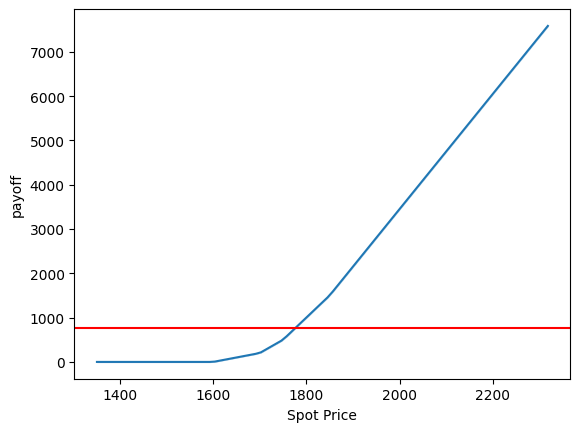

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 770.6906796247273
premium 770.6906796247273
Risk Reward 8.844138165428005
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -27.363650263194355
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


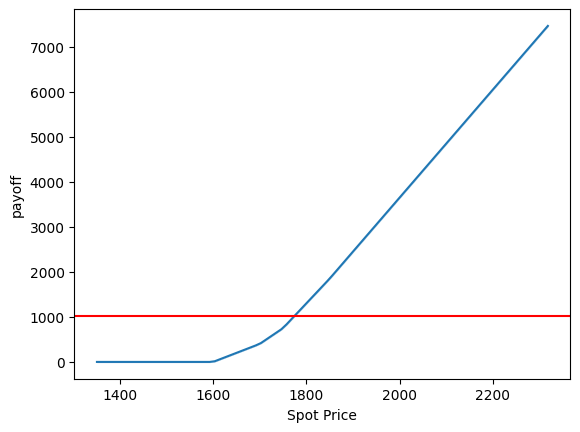

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1026.5759006655617
premium 1026.5759006655617
Risk Reward 6.275225588696864
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -29.32377561051227
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 1, 'map': 1}]


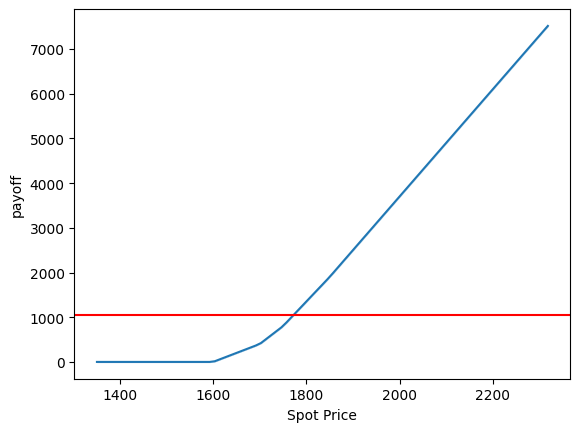

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 1053.369773752971
premium 1053.369773752971
Risk Reward 6.1376371798426295
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -29.471472995068304
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 1, 'map': 1}]


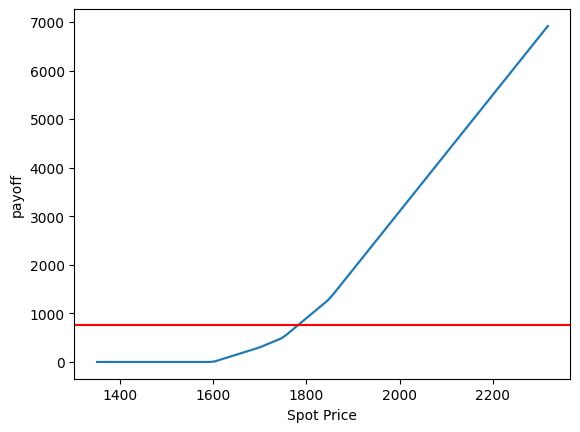

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 764.0967729457094
premium 764.0967729457094
Risk Reward 8.054574637960423
probal 0.550561797752809
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -26.630117256285757
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


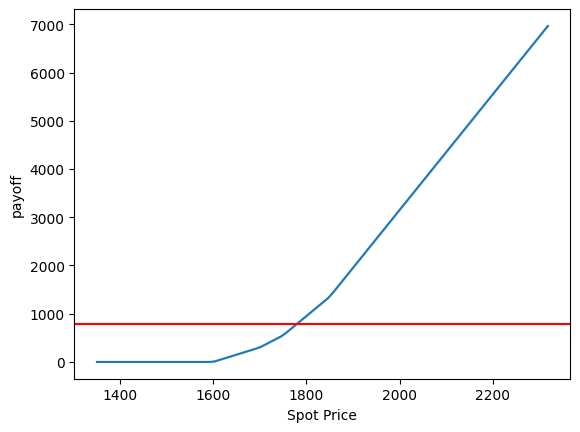

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 790.8906460331189
premium 790.8906460331189
Risk Reward 7.811042710157192
probal 0.550561797752809
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -26.419636365615332
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


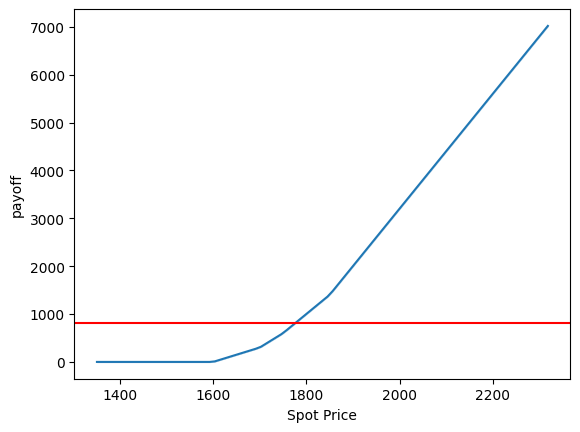

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 817.6845191205282
premium 817.6845191205282
Risk Reward 7.583470882890806
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -26.264771643999993
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


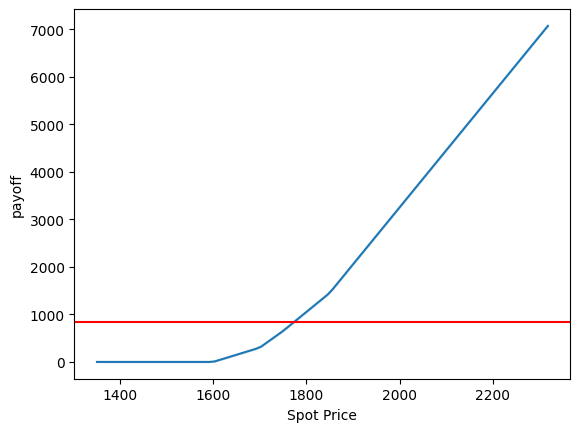

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 844.4783922079376
premium 844.4783922079376
Risk Reward 7.370339995059478
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -26.150393812767327
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


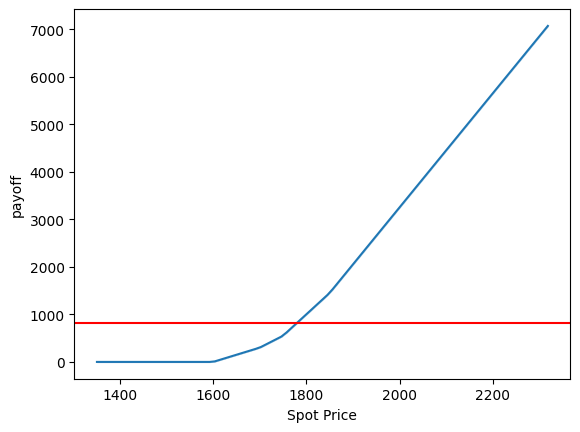

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 815.6548308252283
premium 815.6548308252283
Risk Reward 7.66613056666395
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -26.78175834248543
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


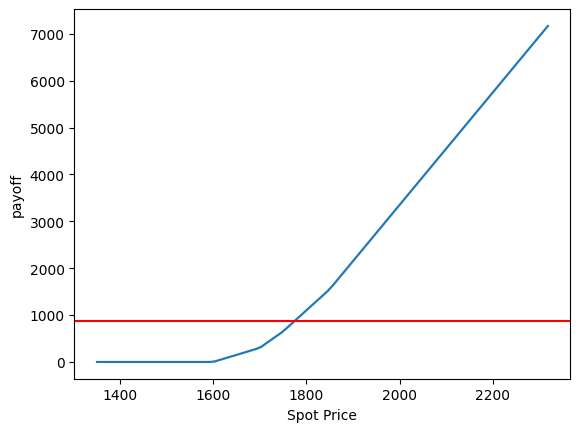

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 869.242577000047
premium 869.242577000047
Risk Reward 7.246916857204564
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -26.65665935952442
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 3, 'map': 1}]


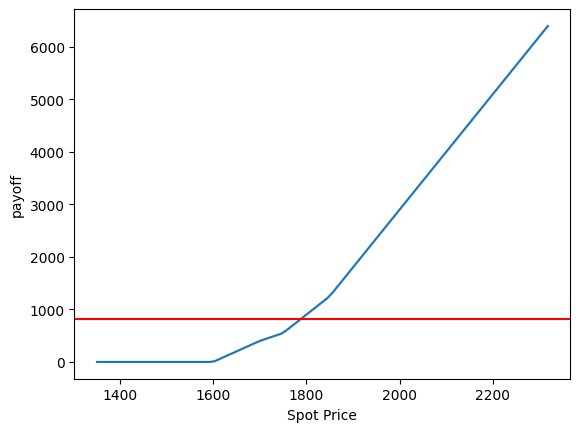

[        Price
0  170.645757,        Price
0  58.652761,       Price
0  36.04693,        Price
0  11.282745]
net premium 813.2489663458815
premium 930.5544877081287
Risk Reward 6.870107746030258
probal 0.550561797752809
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -26.401532890543677
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.353, 'quantity': -1, 'map': -1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


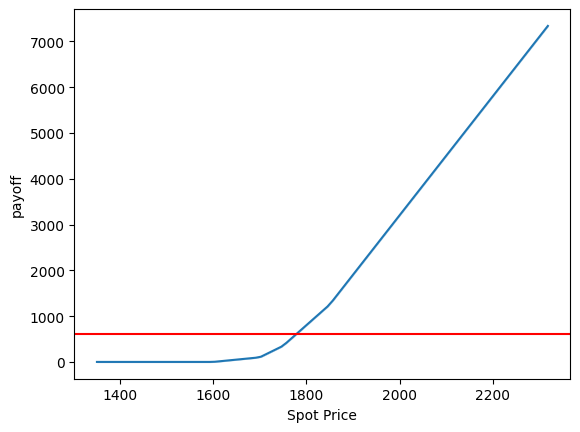

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 611.3276676639127
premium 611.3276676639127
Risk Reward 11.001396176079737
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -25.75107244149578
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


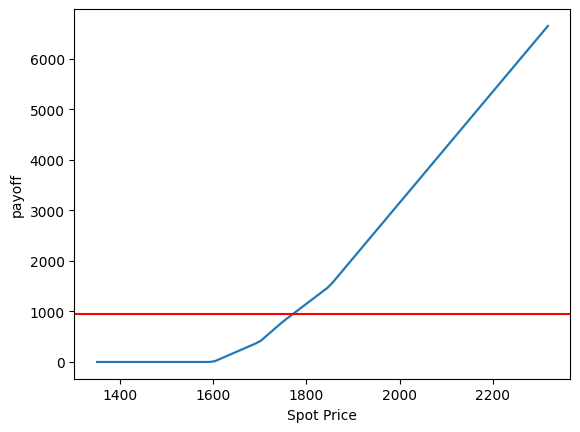

[        Price
0  170.645757,        Price
0  62.840803,        Price
0  33.523838,        Price
0  11.282745]
net premium 945.5533815587141
premium 1012.6010571945715
Risk Reward 6.033296183158823
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -25.57949845129371
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.35, 'quantity': -1, 'map': -1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


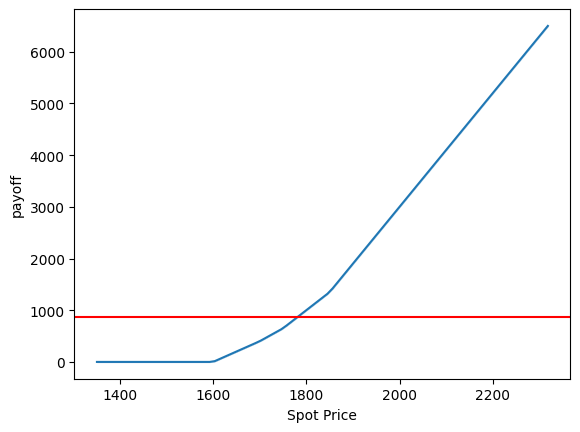

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 862.6486703210293
premium 862.6486703210293
Risk Reward 6.535346906720155
probal 0.550561797752809
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -25.732094337830304
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


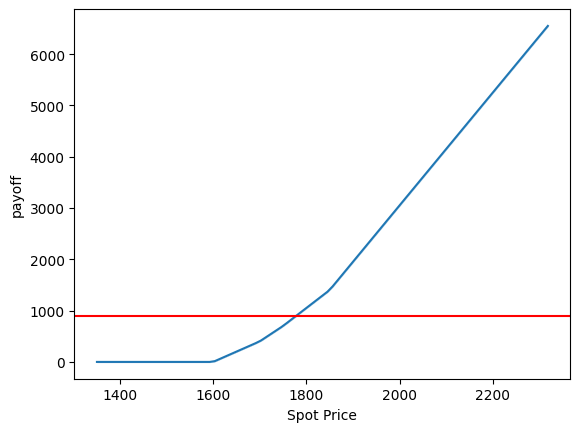

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 889.4425434084387
premium 889.4425434084387
Risk Reward 6.364564510696954
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -25.577229616214964
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 4, 'map': 1}]


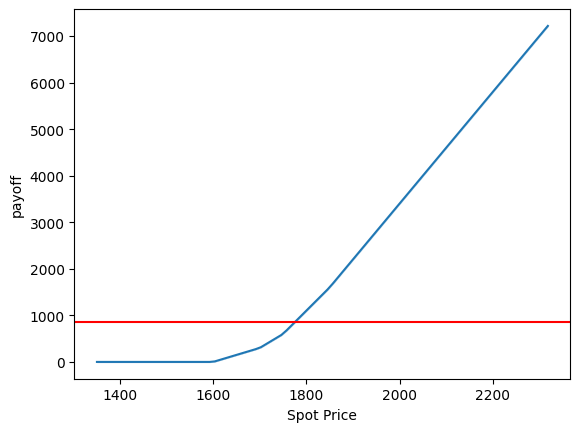

[        Price
0  170.645757,        Price
0  62.840803,       Price
0  36.04693,        Price
0  11.282745]
net premium 867.2128887047471
premium 867.2128887047471
Risk Reward 7.323874512569971
probal 0.5617977528089888
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 1351.0471545187777
best case, vol: 0.85 price: 2318.214271771802
min thetas -27.22953618934824
[{'type': 'C', 'strike': 1600.0, 'expiry': 0.03286056547282471, 'vol': 0.7801, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1700.0, 'expiry': 0.03286056547282471, 'vol': 0.38780000000000003, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 1750.0, 'expiry': 0.03286056547282471, 'vol': 0.3705, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 1850.0, 'expiry': 0.032860565441083206, 'vol': 0.3922, 'quantity': 2, 'map': 1}]


In [14]:
# bule line is the payoff curve, red line stands for net premium, yep this is for plotting
for para in temp.para[:50]:
    model.model_plot(para)